# Модель восстановления золоты из руды

# Содержание
* [Описание проекта](#description)
* [Цели и задачи проекта](#purposes)
* [Исходные данные](#initial_data)
* [Подготовка данных](#preparation)
    * [Знакомство с данными](#first_look)
    * [Приведение дат к нужному формату](#dates)
    * [Удаление нулевых значений](#zeros)
    * [Работа с пропусками](#nan)
    * [Проверка расчета эффективности обогащения чернового и финального концентратов](#efficiency_check)
    * [Анализ признаков, недоступных в тестовой выборке](#feature_analysis)
* [Анализ данных](#data_analysis)
    * [Изменение концентраций металлов на разных этапах очистки](#metals_concentrations)
    * [Распределение размера гранул на обучающей и тестовой выборке](#particle_size_distribution)
    * [Суммарные концентрации всех веществ на разных стадиях процесса](#total_concentrations)
* [Модель](#model)
    * [Метрика качества модели](#metrics)
    * [Разбивка данных на обучающую и валидационную выборки](#split)
    * [Модель дерева решений](#tree)
    * [Модель случайного леса](#forest)
    * [Модель линейной регрессии](#regression)
    * [Испытание лучшей модели на тестовой выборке](#test)
    * [Проверка лучшей модели на адекватность](#adequate)
* [Выводы по проекту](#conclusions)

# Описание проекта <a class='anchor' id='description'></a>

Компания "Цифра" разрабатывает решения для эффективной работы промышленных предприятий, в частности, для золотодобывающей промышленности. Необходимо разработать прототип модели для прогнозирования коэффициента восстановления золота из золотосодержащей руды на основе данных с параметрами добычи и очистки. Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

# Цели и задачи проекта <a class='anchor' id='purposes'></a>

Целью настоящей работы было создание модели для прогнозирования коэффициента восстановления золота из золотосодержащей руды.

Для достижения цели в работе решались следующие задачи:
* Подготовка данных
* Исследовательский анализ данных
* Построение и обучение нескольких моделей, их сравнение по метрике `sMAPE` с выбором лучшей
* Проверка лучшей модели на адекватность

# Исходные данные <a class='anchor' id='initial_data'></a>

**Технологический процесс**
* Rougher feed — исходное сырье
* Rougher additions (или reagent additions) — флотационные реагенты: Xanthate, Sulphate, Depressant
* Xanthate — ксантогенат (промотер, или активатор флотации);
* Sulphate — сульфат (на данном производстве сульфид натрия);
* Depressant — депрессант (силикат натрия).
* Rougher process (англ. «грубый процесс») — флотация
* Rougher tails — отвальные хвосты
* Float banks — флотационная установка
* Cleaner process — очистка
* Rougher Au — черновой концентрат золота
* Final Au — финальный концентрат золота

**Параметры этапов**
* air amount — объём воздуха
* fluid levels — уровень жидкости
* feed size — размер гранул сырья
* feed rate — скорость подачи

**Наименование признаков должно быть такое:**
`[этап].[тип_параметра].[название_параметра]`

Пример: `rougher.input.feed_ag`

Возможные значения для блока `[этап]`:

*rougher* — флотация

*primary_cleaner* — первичная очистка

*secondary_cleaner* — вторичная очистка

*final* — финальные характеристики

Возможные значения для блока `[тип_параметра]`:

*input* — параметры сырья

*output* — параметры продукта

*state* — параметры, характеризующие текущее состояние этапа

*calculation* — расчётные характеристики

## Подготовка данных <a class='anchor' id='preparation'></a>

### Знакомство с данными <a class='anchor' id='first_look'></a>

Импортируем библиотеки

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import warnings
warnings.filterwarnings('ignore')
from matplotlib import rcParams
rcParams['figure.figsize'] = 11.7,8.27
import scipy.stats as st
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor
from tqdm import tqdm

Создадим датафреймы для каждой из анализируемых таблиц.

In [3]:
gold_recovery_full = pd.read_csv('gold_recovery_full_new.csv')
gold_recovery_train = pd.read_csv('gold_recovery_train_new.csv')
gold_recovery_test = pd.read_csv('gold_recovery_test_new.csv')

Выведем информацию о каждом из датафреймов.

In [4]:
def information(
    df: pd.DataFrame
):
    return df.info()

In [5]:
print( 
information(gold_recovery_full),
information(gold_recovery_train),
information(gold_recovery_test)
)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19439 entries, 0 to 19438
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                19439 non-null  object 
 1   final.output.concentrate_ag                         19438 non-null  float64
 2   final.output.concentrate_pb                         19438 non-null  float64
 3   final.output.concentrate_sol                        19228 non-null  float64
 4   final.output.concentrate_au                         19439 non-null  float64
 5   final.output.recovery                               19439 non-null  float64
 6   final.output.tail_ag                                19438 non-null  float64
 7   final.output.tail_pb                                19338 non-null  float64
 8   final.output.tail_sol                               19433 non-null  float64


Сразу отметим следующие наблюдения:
* Видно, что в данных есть пропуски. 
* Даты нужно привести к типу datetime

Посмотрим, в каких столбцах есть пропуски.

In [6]:
def nan_col(
    df: pd.DataFrame
):
    col_list = []
    for column in df.columns:
        if df[column].isna().sum() != 0:
            col_list.append(column)
    return col_list, len(col_list) / df.shape[1] * 100

In [7]:
for df in [
    gold_recovery_full, 
    gold_recovery_train, 
    gold_recovery_test
]:
    full_na, full_na_percent = nan_col(df) # распаковываем кортеж 
    print(full_na_percent) # смотрим, какой % признаков содержит пропуски

72.41379310344827
71.26436781609196
22.641509433962266


Наибольшее количество признаков с пропусками в исходных данных и данных для обучения. Наименьшее - в тестовой выборке.

Проверим, есть ли полные дубликаты.

In [8]:
def duplicates(
    df: pd.DataFrame
):
    return df.duplicated().sum()

In [9]:
for df in [
    gold_recovery_full, 
    gold_recovery_train, 
    gold_recovery_test
]:
    print(duplicates(df))

0
0
0


Полных дубликатов ни в одном из датафреймов нет.

Посмотрим на распределения целевых признаков в каждом из датафреймов.

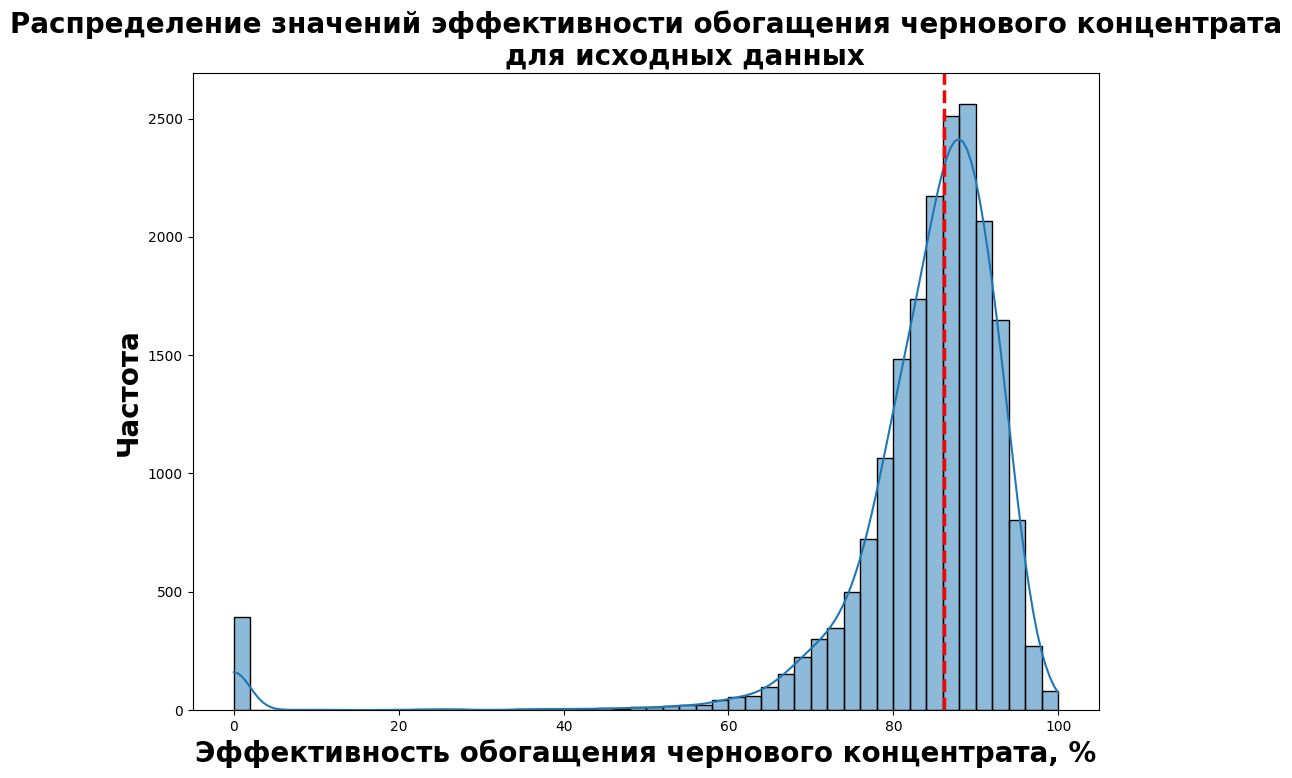

In [10]:
(
    sns.histplot(
        data=gold_recovery_full['rougher.output.recovery'], 
        bins=50,
        kde=True
    )
    .set_title(
        '''Распределение значений эффективности обогащения чернового концентрата
        для исходных данных''', 
        fontdict={'size': 20, 'weight': 'bold'})
)
plt.xlabel('Эффективность обогащения чернового концентрата, %', fontdict={'size': 20, 'weight': 'bold'})
plt.ylabel('Частота', fontdict={'size': 20, 'weight': 'bold'})
plt.axvline(x=gold_recovery_full['rougher.output.recovery'].median(), color='red', ls='--', lw='2.5')
plt.show()

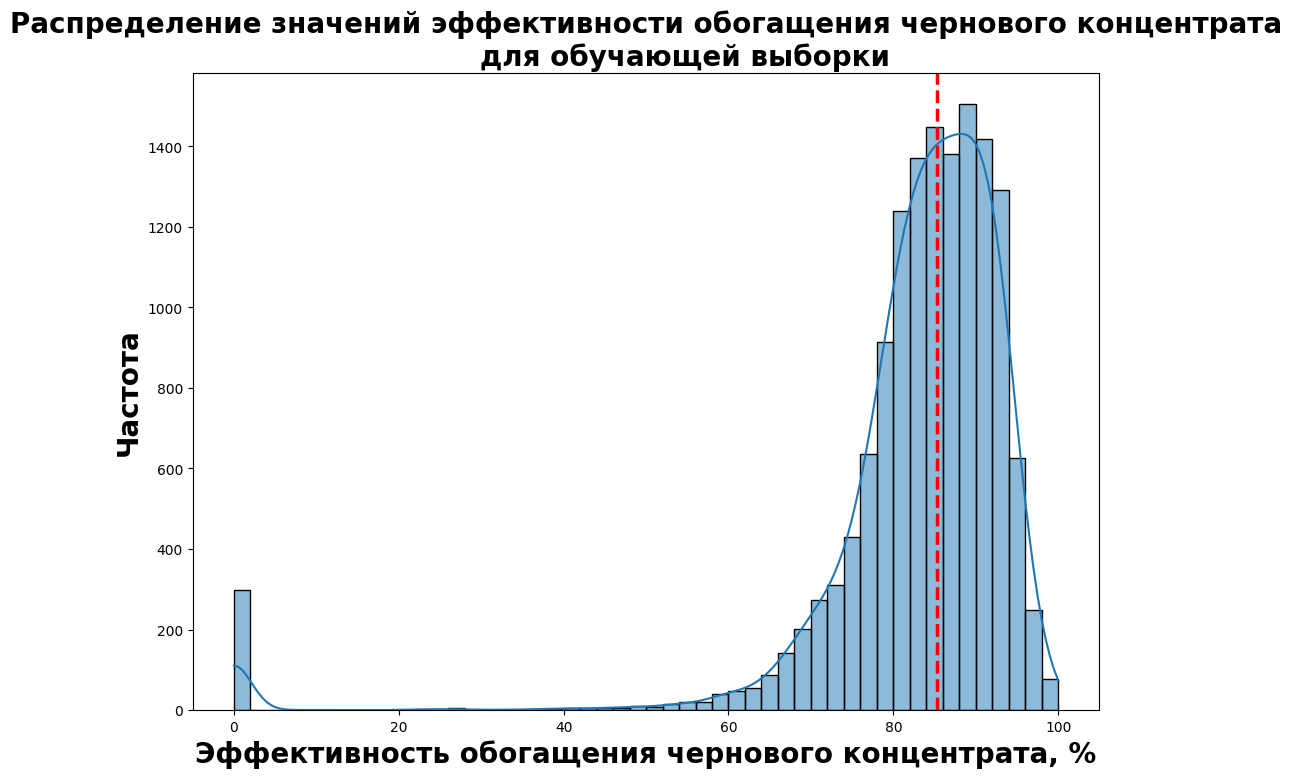

In [11]:
(
    sns.histplot(
        data=gold_recovery_train['rougher.output.recovery'], 
        bins=50,
        kde=True
    )
    .set_title(
        '''Распределение значений эффективности обогащения чернового концентрата
        для обучающей выборки''', 
        fontdict={'size': 20, 'weight': 'bold'})
)
plt.xlabel('Эффективность обогащения чернового концентрата, %', fontdict={'size': 20, 'weight': 'bold'})
plt.ylabel('Частота', fontdict={'size': 20, 'weight': 'bold'})
plt.axvline(x=gold_recovery_train['rougher.output.recovery'].median(), color='red', ls='--', lw='2.5')
plt.show()

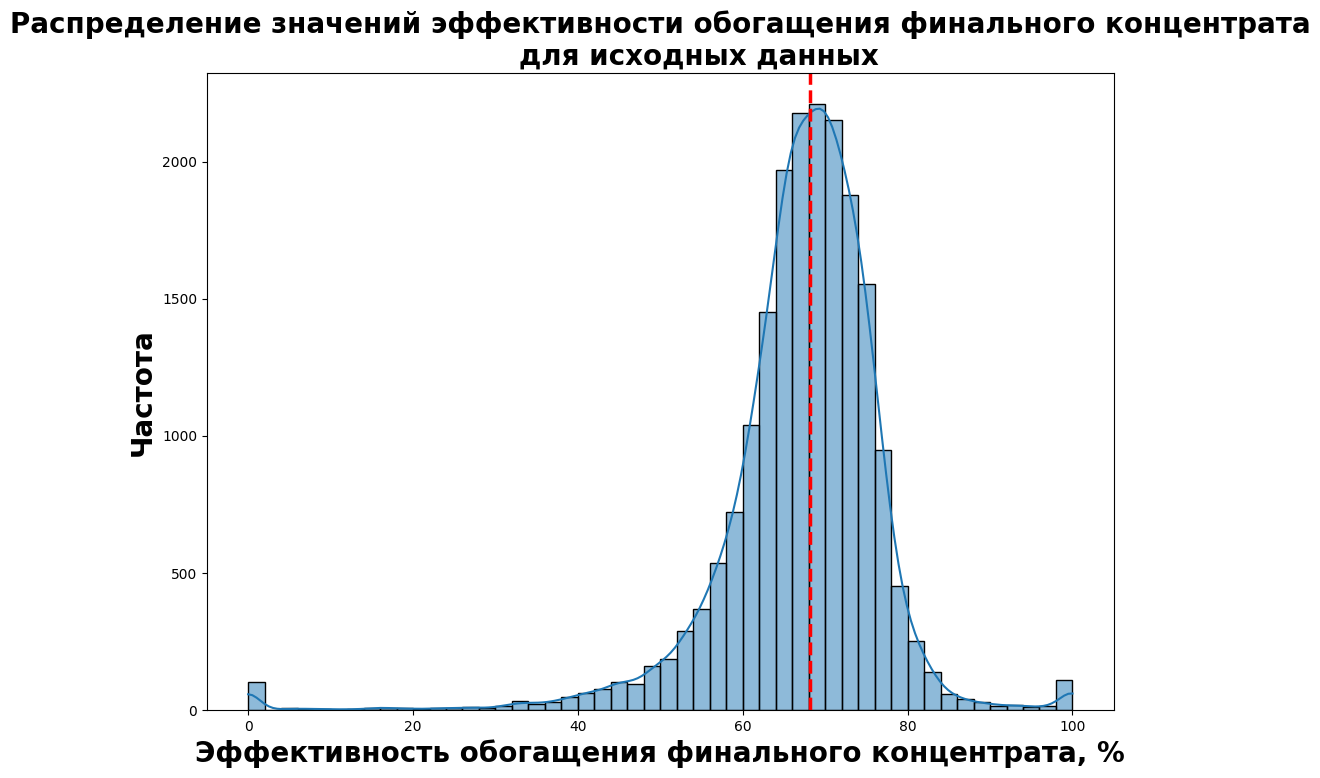

In [12]:
(
    sns.histplot(
        data=gold_recovery_full['final.output.recovery'], 
        bins=50,
        kde=True
    )
    .set_title(
        '''Распределение значений эффективности обогащения финального концентрата
        для исходных данных''', 
        fontdict={'size': 20, 'weight': 'bold'})
)
plt.xlabel('Эффективность обогащения финального концентрата, %', fontdict={'size': 20, 'weight': 'bold'})
plt.ylabel('Частота', fontdict={'size': 20, 'weight': 'bold'})
plt.axvline(x=gold_recovery_full['final.output.recovery'].median(), color='red', ls='--', lw='2.5')
plt.show()

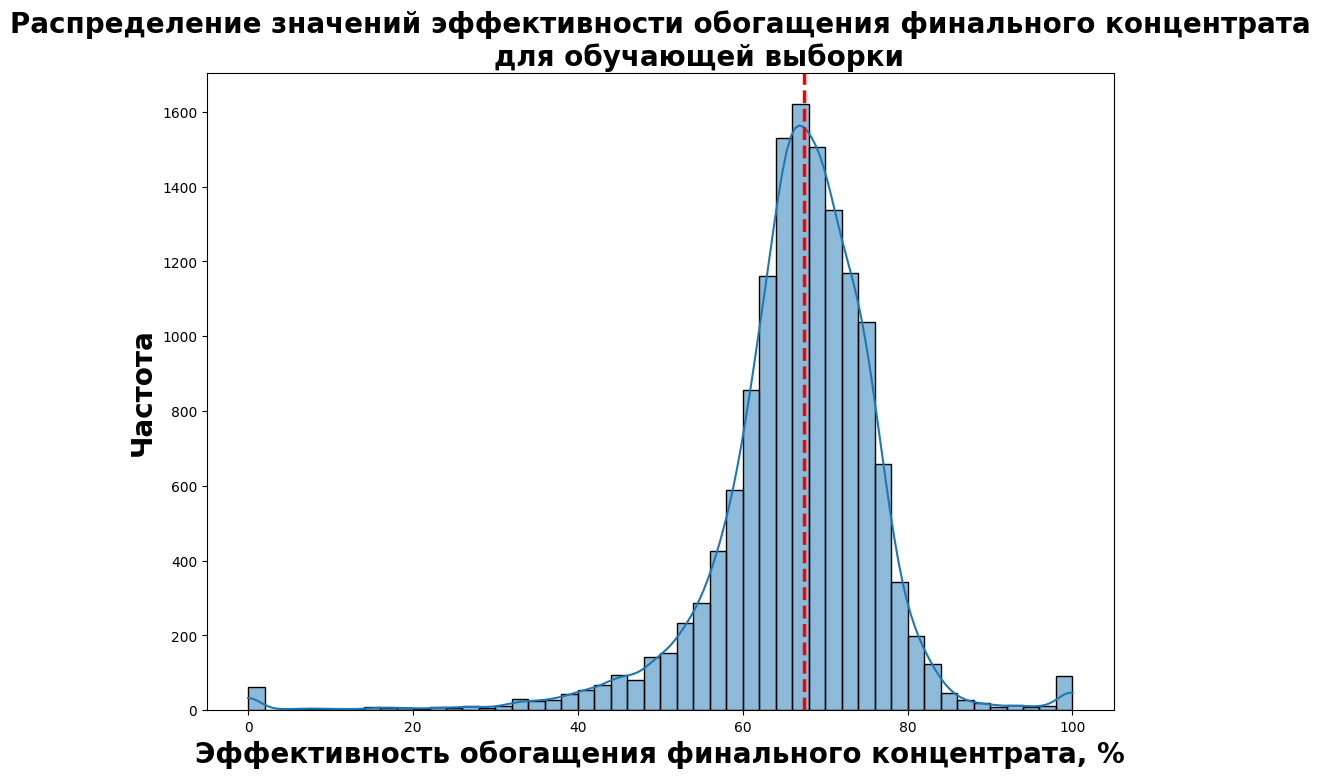

In [13]:
(
    sns.histplot(
        data=gold_recovery_train['final.output.recovery'], 
        bins=50,
        kde=True
    )
    .set_title(
        '''Распределение значений эффективности обогащения финального концентрата
        для обучающей выборки''', 
        fontdict={'size': 20, 'weight': 'bold'})
)
plt.xlabel('Эффективность обогащения финального концентрата, %', fontdict={'size': 20, 'weight': 'bold'})
plt.ylabel('Частота', fontdict={'size': 20, 'weight': 'bold'})
plt.axvline(x=gold_recovery_train['final.output.recovery'].median(), color='red', ls='--', lw='2.5')
plt.show()

Исходя из полученных распределений, отметим:
* Распределение эффективности обогащения чернового концентрата имеет вид Пуассоновского правоскошенного.
* Распределение эффективности обогащения финального концентрата имеет вид нормального распределения.
* Как для эффективности обогащения чернового концентрата, так и для финального присутствуют нулевые значения. Видимо, в это время происходил останов производства или датчики были неисправны. Нужно будет убрать эти строки.

Посмотрим на распределение скорости подачи сырья.

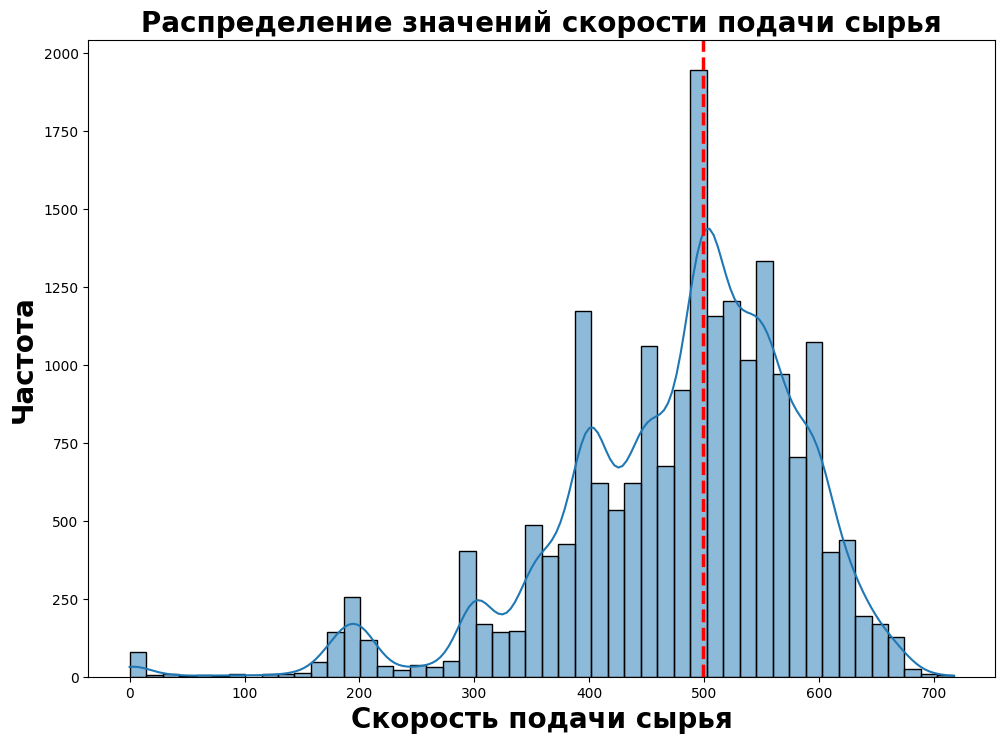

In [14]:
sns.histplot(
    data=gold_recovery_full['rougher.input.feed_rate'],
    bins=50,
    kde=True
)
plt.xlabel('Скорость подачи сырья', fontdict={'size': 20, 'weight': 'bold'})
plt.ylabel('Частота', fontdict={'size': 20, 'weight': 'bold'})
plt.title('Распределение значений скорости подачи сырья', fontdict={'size': 20, 'weight': 'bold'})
plt.axvline(x=gold_recovery_full['rougher.input.feed_rate'].median(), color='red', ls='--', lw='2.5')
plt.show()

Распределение значений скорости подачи сырья близко к нормальному. Медиана равна 500. Присутствуют нулевые значения, соответствующие останову производству или сбою датчиков. Нужно будет от них избавиться. 

Уже видна тенденция к тому, что во всех 3 таблицах есть признаки с нулевыми значениями. Для быстроты выведем названия всех признаков, принимающих нулевое значение хотя бы 1 раз и количество нулевых значений. Для оценки возьмем таблицу с исходными данными.

In [15]:
for column in gold_recovery_full.columns:
    if len(gold_recovery_full[gold_recovery_full[column] == 0]) > 0:
        print(column, len(gold_recovery_full[gold_recovery_full[column] == 0]))

final.output.concentrate_ag 98
final.output.concentrate_pb 98
final.output.concentrate_sol 98
final.output.concentrate_au 98
final.output.recovery 98
final.output.tail_ag 91
final.output.tail_pb 91
final.output.tail_sol 91
final.output.tail_au 91
primary_cleaner.input.depressant 10
primary_cleaner.output.concentrate_ag 108
primary_cleaner.output.concentrate_pb 108
primary_cleaner.output.concentrate_sol 108
primary_cleaner.output.concentrate_au 108
primary_cleaner.output.tail_ag 124
primary_cleaner.output.tail_pb 124
primary_cleaner.output.tail_sol 124
primary_cleaner.output.tail_au 124
rougher.output.concentrate_ag 394
rougher.output.concentrate_pb 394
rougher.output.concentrate_sol 394
rougher.output.concentrate_au 394
rougher.output.recovery 394
secondary_cleaner.output.tail_ag 849
secondary_cleaner.output.tail_pb 849
secondary_cleaner.output.tail_sol 849
secondary_cleaner.output.tail_au 849
secondary_cleaner.state.floatbank2_b_air 8
secondary_cleaner.state.floatbank3_a_air 2
seconda

На всех этапах производства встречаются нулевые значения, видимо, связанные с остановами или сбоем датчиков. В ходе предобработки нужно будет удалить данные строки, поскольку обучать модель в такие периоды некорректно. 

**Промежуточные выводы**
* 3 исследуемых датафрейма имеют разное количество строк и столбцов: исходные данные и обучающая выборка отличаются только количеством строк, а тестовая выборка имеет еще и меньшее количество признаков, по сравнению с исходными данными.
* Во всех датафреймах нужно привести даты к формату `datetime`.
* Необходимо убрать строки, где встречаются нулевые значения, т.к. в эти периоды был останов производства либо датчики сбоили.
* Нужно разобраться с пропусками, в первую очередь, в исходных данных и обучающей выборке, поскольку их там примерно в 3 раза больше, по сравнению с тестовой выборкой. 

### Приведение дат к нужному формату <a class='anchor' id='dates'></a>

Посмотрим, в каком формате представлены даты.

In [16]:
gold_recovery_full['date'].head()

0    2016-01-15 00:00:00
1    2016-01-15 01:00:00
2    2016-01-15 02:00:00
3    2016-01-15 03:00:00
4    2016-01-15 04:00:00
Name: date, dtype: object

Напишем функцию для приведения дат к формату `datetime`

In [17]:
def dates_converter(
    df: pd.DataFrame
):
    df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d %H:%M:%S')
    return df['date']

Применим функцию ко всем датафреймам и проверим результат.

In [18]:
for df in [
    gold_recovery_full, 
    gold_recovery_train, 
    gold_recovery_test
]:
    dates_converter(df)
gold_recovery_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19439 entries, 0 to 19438
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype         
---  ------                                              --------------  -----         
 0   date                                                19439 non-null  datetime64[ns]
 1   final.output.concentrate_ag                         19438 non-null  float64       
 2   final.output.concentrate_pb                         19438 non-null  float64       
 3   final.output.concentrate_sol                        19228 non-null  float64       
 4   final.output.concentrate_au                         19439 non-null  float64       
 5   final.output.recovery                               19439 non-null  float64       
 6   final.output.tail_ag                                19438 non-null  float64       
 7   final.output.tail_pb                                19338 non-null  float64       
 8   final.

### Удаление нулевых значений <a class='anchor' id='zeros'></a>

In [19]:
len(gold_recovery_full[gold_recovery_full['secondary_cleaner.output.tail_ag'] == 0])

849

In [20]:
# Пишем функцию для удаления строк с нулевыми значениями
def drop_nulls(table: pd.DataFrame):
    for column in table.columns:
        table = table.drop(table[table[column] == 0].index)
    return table

# Удаляем строки с нулевыми значениями в каждой из таблиц
gold_recovery_full = drop_nulls(gold_recovery_full)
gold_recovery_train = drop_nulls(gold_recovery_train)
gold_recovery_test = drop_nulls(gold_recovery_test)

Проверим правильность

In [21]:
print(len(gold_recovery_full[gold_recovery_full['secondary_cleaner.output.tail_ag'] == 0]))

0


In [22]:
print(gold_recovery_full.shape, gold_recovery_train.shape, gold_recovery_test.shape, sep='\n')

(17894, 87)
(12936, 87)
(5289, 53)


### Работа с пропусками <a class='anchor' id='nan'></a>

Здесь и далее будем работать с обучающей и тестовой выборками.

Пропуски есть почти во всех признаках исходных данных. Они могут быть связаны с отсутствием данных по конкретному показателю за выбранную дату. Удалять все строки с пропусками не следует, так как потеряем значения признаков, где пропусков нет. А это подпортит качество модели. Чтобы понять, при каком минимальном числе заполненных ячеек оставлять строку, построим графики зависимостей числа наблюдений от числа признаков без учета пропусков.

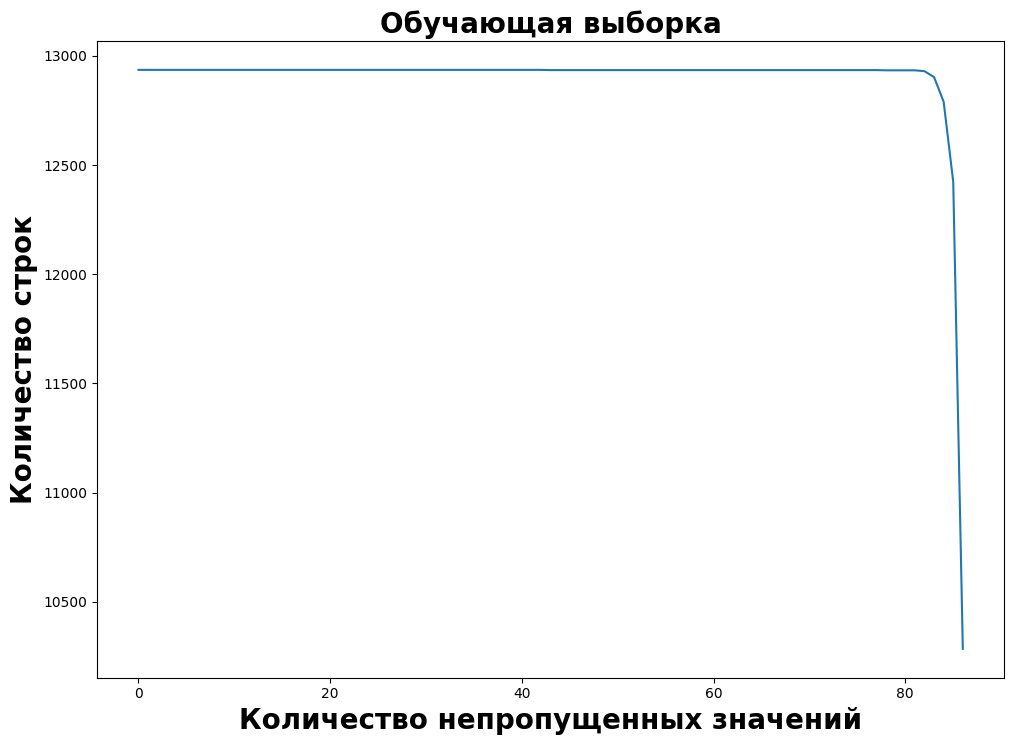

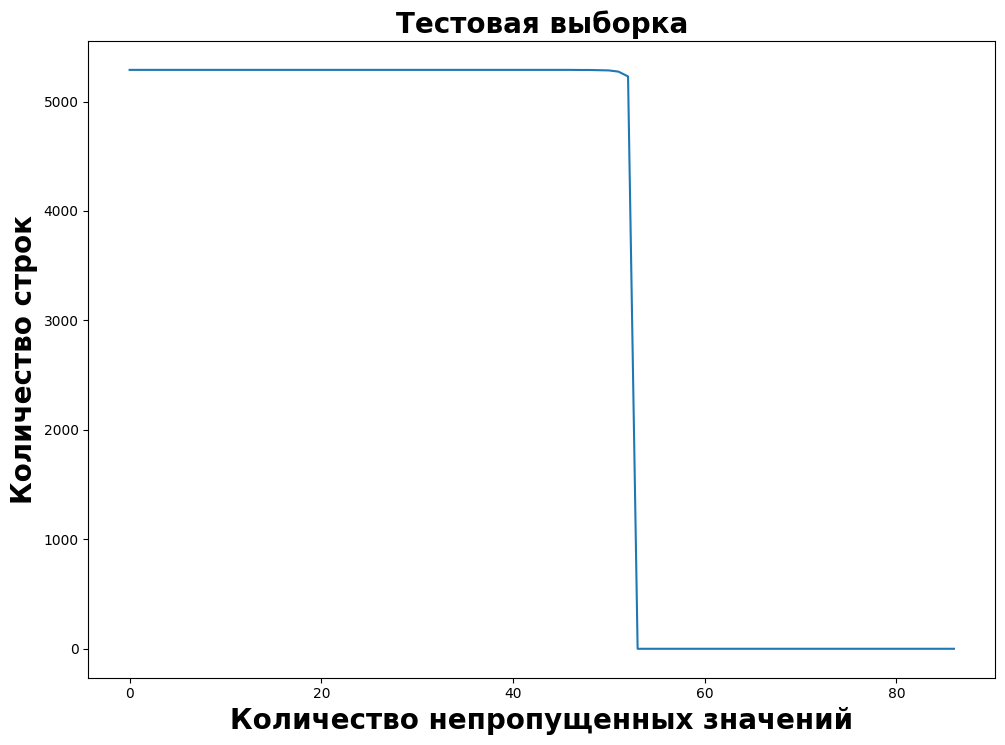

In [23]:
def min_str(
    df: pd.DataFrame,
    title_: str
):
    values = []
    for i in range(1, 88):
        values.append(df.dropna(axis=0, thresh=i).shape[0])
    sns.lineplot(data=values, markers=True)
    plt.xlabel('Количество непропущенных значений', fontdict={'size': 20, 'weight': 'bold'})
    plt.ylabel('Количество строк', fontdict={'size': 20, 'weight': 'bold'})
    plt.title(title_, fontdict={'size': 20, 'weight': 'bold'})
    plt.show()
min_str(gold_recovery_train, 'Обучающая выборка')
min_str(gold_recovery_test, 'Тестовая выборка')

Заметим, что как для обучающей, так и для тестовой выборки практически все строки являются информативными.

Проанализируем, сколько пропусков в процентном соотношении содержится в каждом столбце.

In [24]:
def nan_percent(df: pd.DataFrame):
    display((df.isna().sum().sort_values(ascending=False)/len(df)*100)[:20])

In [25]:
nan_percent(gold_recovery_train)

secondary_cleaner.output.tail_sol           12.059369
rougher.state.floatbank10_e_air              2.752010
primary_cleaner.output.concentrate_sol       1.878479
final.output.concentrate_sol                 1.553803
secondary_cleaner.state.floatbank2_a_air     1.522882
rougher.input.floatbank11_xanthate           0.943105
rougher.input.feed_size                      0.919913
final.output.tail_pb                         0.773036
rougher.input.feed_pb                        0.765306
primary_cleaner.input.xanthate               0.595238
primary_cleaner.output.concentrate_pb        0.510204
rougher.input.feed_sol                       0.371058
primary_cleaner.output.tail_sol              0.286024
rougher.input.floatbank11_sulfate            0.208720
rougher.input.floatbank10_sulfate            0.139147
rougher.output.concentrate_sol               0.139147
primary_cleaner.output.tail_pb               0.115955
primary_cleaner.input.depressant             0.115955
secondary_cleaner.output.tai

Существенное количество пропусков в обучающей выборке находится только в столбце `secondary_cleaner.output.tail_sol`. Для всех остальных столбцов можно удалить пропуски.

In [26]:
for column in gold_recovery_train.columns:
    if column != 'secondary_cleaner.output.tail_sol':
        gold_recovery_train = gold_recovery_train.dropna(subset=[column])

In [27]:
gold_recovery_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11497 entries, 0 to 14139
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype         
---  ------                                              --------------  -----         
 0   date                                                11497 non-null  datetime64[ns]
 1   final.output.concentrate_ag                         11497 non-null  float64       
 2   final.output.concentrate_pb                         11497 non-null  float64       
 3   final.output.concentrate_sol                        11497 non-null  float64       
 4   final.output.concentrate_au                         11497 non-null  float64       
 5   final.output.recovery                               11497 non-null  float64       
 6   final.output.tail_ag                                11497 non-null  float64       
 7   final.output.tail_pb                                11497 non-null  float64       
 8   final.outpu

In [28]:
nan_percent(gold_recovery_test)

rougher.input.floatbank11_xanthate            0.472679
rougher.input.feed_sol                        0.397050
secondary_cleaner.state.floatbank3_a_air      0.170164
rougher.input.floatbank11_sulfate             0.151257
primary_cleaner.input.depressant              0.075629
rougher.input.floatbank10_sulfate             0.075629
rougher.input.feed_rate                       0.056721
primary_cleaner.input.xanthate                0.056721
secondary_cleaner.state.floatbank2_a_air      0.056721
primary_cleaner.input.sulfate                 0.056721
secondary_cleaner.state.floatbank2_b_air      0.037814
rougher.input.feed_size                       0.018907
secondary_cleaner.state.floatbank2_b_level    0.000000
rougher.state.floatbank10_f_level             0.000000
rougher.state.floatbank10_f_air               0.000000
secondary_cleaner.state.floatbank3_a_level    0.000000
secondary_cleaner.state.floatbank2_a_level    0.000000
date                                          0.000000
rougher.st

В случае тестовой выборки можно удалить все пропущенные значения, так как их много меньше суммарного числа строк.

In [29]:
gold_recovery_test = gold_recovery_test.dropna()
gold_recovery_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5229 entries, 0 to 5289
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype         
---  ------                                      --------------  -----         
 0   date                                        5229 non-null   datetime64[ns]
 1   primary_cleaner.input.sulfate               5229 non-null   float64       
 2   primary_cleaner.input.depressant            5229 non-null   float64       
 3   primary_cleaner.input.feed_size             5229 non-null   float64       
 4   primary_cleaner.input.xanthate              5229 non-null   float64       
 5   primary_cleaner.state.floatbank8_a_air      5229 non-null   float64       
 6   primary_cleaner.state.floatbank8_a_level    5229 non-null   float64       
 7   primary_cleaner.state.floatbank8_b_air      5229 non-null   float64       
 8   primary_cleaner.state.floatbank8_b_level    5229 non-null   float64       
 9   primary_clean

### Проверка расчета эффективности обогащения чернового и финального концентратов <a class='anchor' id='efficiency_check'></a>

Проанализируем правильность расчета эффективности обогащения на примере чернового концентрата. Используем обучающую выборку. Для этого сначала напишем соответствующую функцию, а затем добавим новый столбец с расчетными значениями эффективности. 

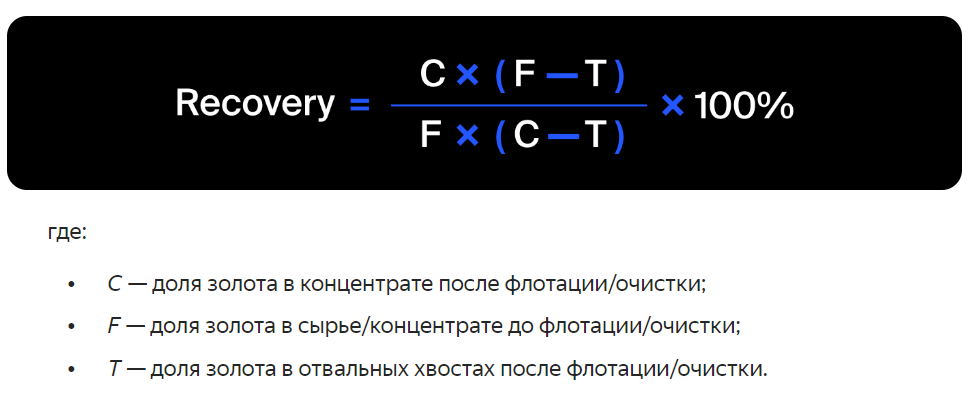

In [30]:
def recovery_rougher(
    row: pd.Series
):
    C = row['rougher.output.concentrate_au']
    F = row['rougher.input.feed_au']
    T = row['rougher.output.tail_au'] 
    recovery_rougher = (C * (F - T)) / (F * (C - T)) * 100
    return recovery_rougher 

In [31]:
gold_recovery_train['recovery_rougher_calc'] = gold_recovery_train.apply(recovery_rougher, axis=1) 
MAE_rougher = mean_absolute_error(gold_recovery_train['rougher.output.recovery'], gold_recovery_train['recovery_rougher_calc'])
print(MAE_rougher)

9.96409955405081e-15


Метрика MAE для эффективности обогащения чернового концентрата на обучающей выборке ничтожно мала. Предоставлены верные данные.

### Анализ признаков, недоступных в тестовой выборке <a class='anchor' id='feature_analysis'></a>

Создадим списки, содержащие названия признаков для обучающей и тестовой выборок.

In [32]:
gold_recovery_train_columns = gold_recovery_train.columns.to_list()
gold_recovery_test_columns = gold_recovery_test.columns.to_list()

Посмотрим, каких признаков нет в тестовой выборке.

In [33]:
for column in gold_recovery_train_columns:
    if column not in gold_recovery_test_columns:
        print(column)

final.output.concentrate_ag
final.output.concentrate_pb
final.output.concentrate_sol
final.output.concentrate_au
final.output.recovery
final.output.tail_ag
final.output.tail_pb
final.output.tail_sol
final.output.tail_au
primary_cleaner.output.concentrate_ag
primary_cleaner.output.concentrate_pb
primary_cleaner.output.concentrate_sol
primary_cleaner.output.concentrate_au
primary_cleaner.output.tail_ag
primary_cleaner.output.tail_pb
primary_cleaner.output.tail_sol
primary_cleaner.output.tail_au
rougher.calculation.sulfate_to_au_concentrate
rougher.calculation.floatbank10_sulfate_to_au_feed
rougher.calculation.floatbank11_sulfate_to_au_feed
rougher.calculation.au_pb_ratio
rougher.output.concentrate_ag
rougher.output.concentrate_pb
rougher.output.concentrate_sol
rougher.output.concentrate_au
rougher.output.recovery
rougher.output.tail_ag
rougher.output.tail_pb
rougher.output.tail_sol
rougher.output.tail_au
secondary_cleaner.output.tail_ag
secondary_cleaner.output.tail_pb
secondary_cleaner.

В основном отсутствуют параметры продуктов на каждом этапе производственного процесса. Как сказано в условии, отсутствие некоторых признаков в тестовой выборке объясняется тем, что значения этих признаков замеряются и/или рассчитываются значительно позже. Однако для оценки точности моделей понадобятся значения целевых признаков: `final.output.recovery` и `rougher.output.recovery`. Их тоже нет в тестовой выборке, но они присутствуют в исходных данных. Добавим эти признаки в тестовую выборку, используя объединение таблиц.

In [34]:
gold_recovery_test_merged = gold_recovery_test.copy(deep=True) 
gold_recovery_test_merged = pd.merge(gold_recovery_test, gold_recovery_full, on='date', how='left')

In [35]:
gold_recovery_test['final.output.recovery'] = gold_recovery_test_merged['final.output.recovery'] 
gold_recovery_test['rougher.output.recovery'] = gold_recovery_test_merged['rougher.output.recovery'] 
gold_recovery_test.head()

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,...,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level,final.output.recovery,rougher.output.recovery
0,2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,...,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414,70.273583,89.993421
1,2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,...,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438,68.910432,88.089657
2,2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,...,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559,68.143213,88.412756
3,2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,...,8.074946,-499.474407,7.897085,-500.868509,4.931400,-499.963623,24.948919,-498.709987,67.776393,87.360133
4,2016-09-01 04:59:59,199.099327,10.682530,7.530000,0.805575,1401.268123,-500.808305,1398.128818,-499.504543,1402.172226,...,8.054678,-500.397500,8.107890,-509.526725,4.957674,-500.360026,25.003331,-500.856333,61.467078,83.236367


**Выводы по предобработке данных**
* В данных присутствовали нулевые значения, соответствующие, по-видимому, остановам производства либо сбоям датчиков. Строки с такими значениями были удалены.
* В данных обнаружены пропуски. Для обучающей выборки удалены строки с пропусками во всех столбцах, кроме `secondary_cleaner.output.tail_sol`, где доля пропущенных значений составляла порядка 12% от всего датафрейма. Для тестовой выборки удалены все строки с пропусками, поскольку их суммарное количество составляло не более 3% от всего датафрейма.
* Данные приведены к типу `datetime`.
* Проверена правильность расчета эффективности обогащения чернового концентрата на обучающей выборке. MAE составило `9.9641e-15`, что ничтожно мало, значит, предоставленные данные верны.
* Обнаружено, что в тестовой выборке отсутствовал ряд признаков, которые есть в обучающей. Это параметры продуктов после каждого этапа обогащения. Также в тестовой выборке отсутствовали целевые признаки: `final.output.recovery` и `rougher.output.recovery`, необходимые для оценки точности модели. Они были добавлены из исходных данных.

## Анализ данных <a class='anchor' id='data_analysis'></a>

### Изменение концентраций металлов на разных этапах очистки <a class='anchor' id='metals_concentrations'></a>

Посмотрим распределения концентраций металлов на всех этапах очистки на примере обучающей выборки.

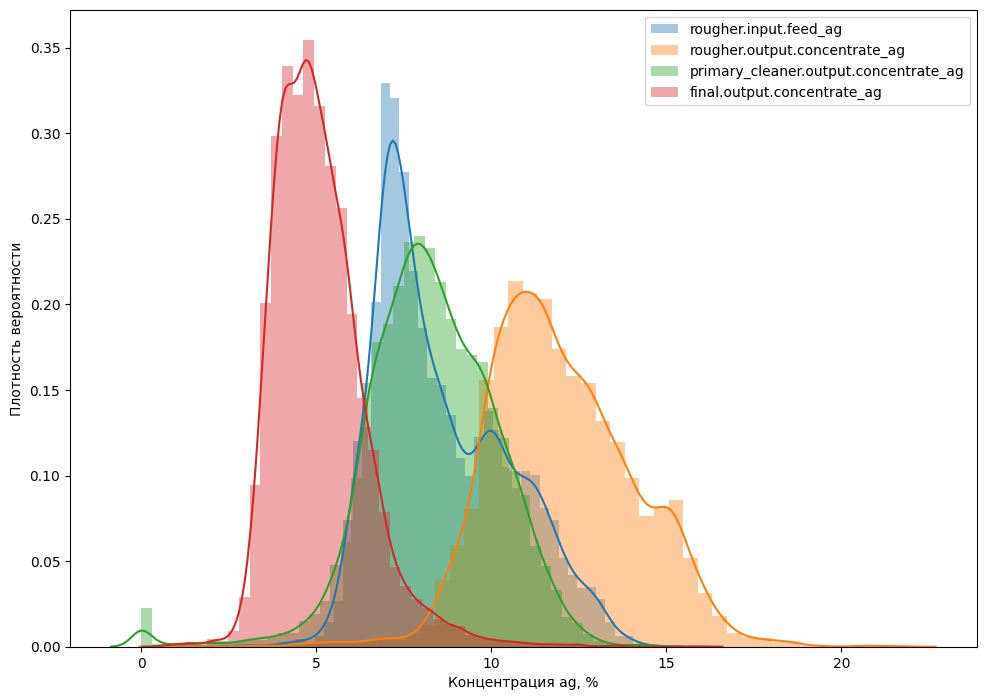

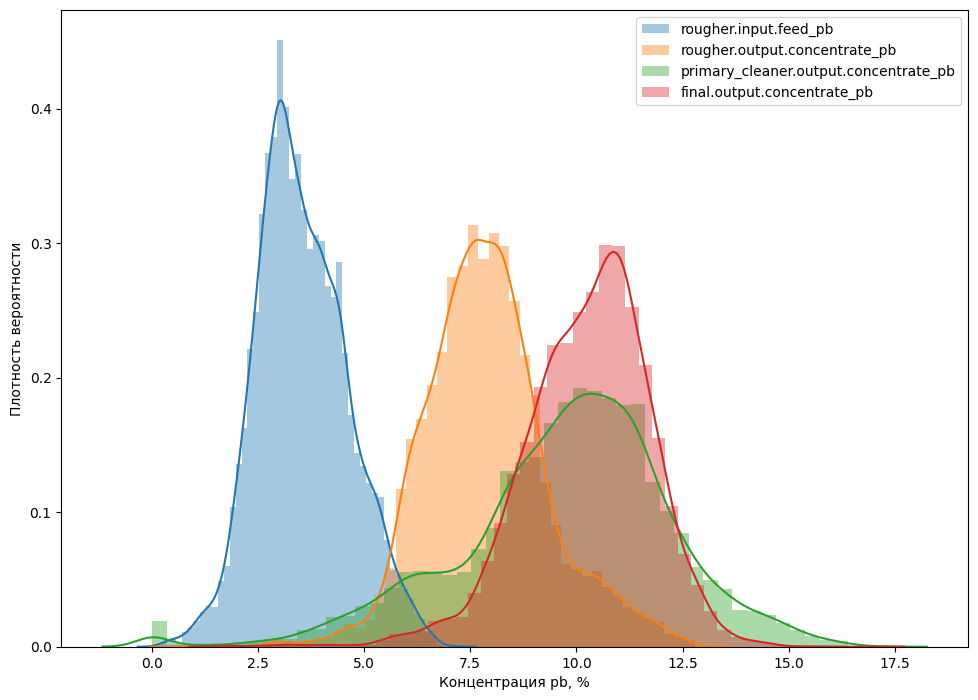

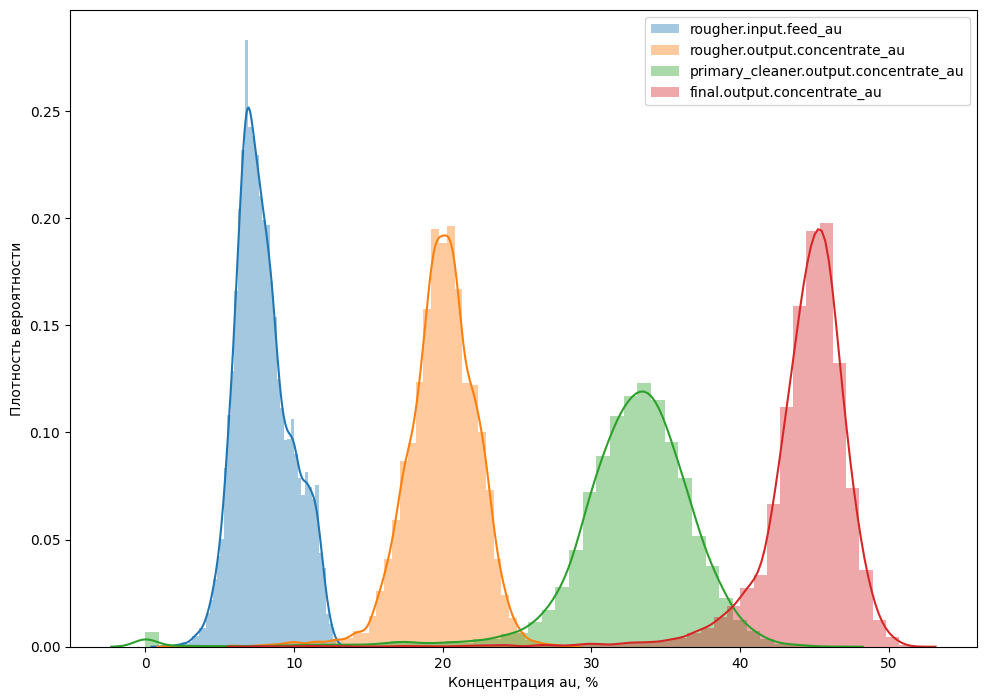

In [36]:
# Создаем словарь с названиями металлов и списками концентраций на разных этапах очистки
metal_concentration = {
    'ag':['rougher.input.feed_ag', 'rougher.output.concentrate_ag','primary_cleaner.output.concentrate_ag','final.output.concentrate_ag'],   
    'pb':['rougher.input.feed_pb', 'rougher.output.concentrate_pb','primary_cleaner.output.concentrate_pb','final.output.concentrate_pb'],   
    'au':['rougher.input.feed_au', 'rougher.output.concentrate_au','primary_cleaner.output.concentrate_au','final.output.concentrate_au']
}

# Строим распределения концентраций на разных этапах очистки
for k in metal_concentration:
    f, ax = plt.subplots()
    for v in metal_concentration[k]: 
        sns.distplot(gold_recovery_train[v], label=v)
    ax.set(xlabel=f'Концентрация {k}, %', ylabel='Плотность вероятности')
    plt.legend()
    plt.show()

**Промежуточные выводы:**
* **Для концентрации каждого металла после проведения флотации характерно ее повышение, по сравнению с исходным сырьем. Это может быть связано с тем, что на этапе флотации из руды извлекают примеси, следовательно, суммарное количество руды снижается, значит, доли оставшихся компонентов пропорционально вырастут**
* Концентрация серебра в руде падает с 12 до 4 % с каждым последующим этапом
* Концентрация свинца увеличивается с 7.5% до уровня 10-11% после флотации и очистки
* Концентрация золота повышается с каждым последующим этапом: с 20% до 32% - после флотации и до 45% после очистки

### Распределение размера гранул на обучающей и тестовой выборке <a class='anchor' id='particle_size_distribution'></a>

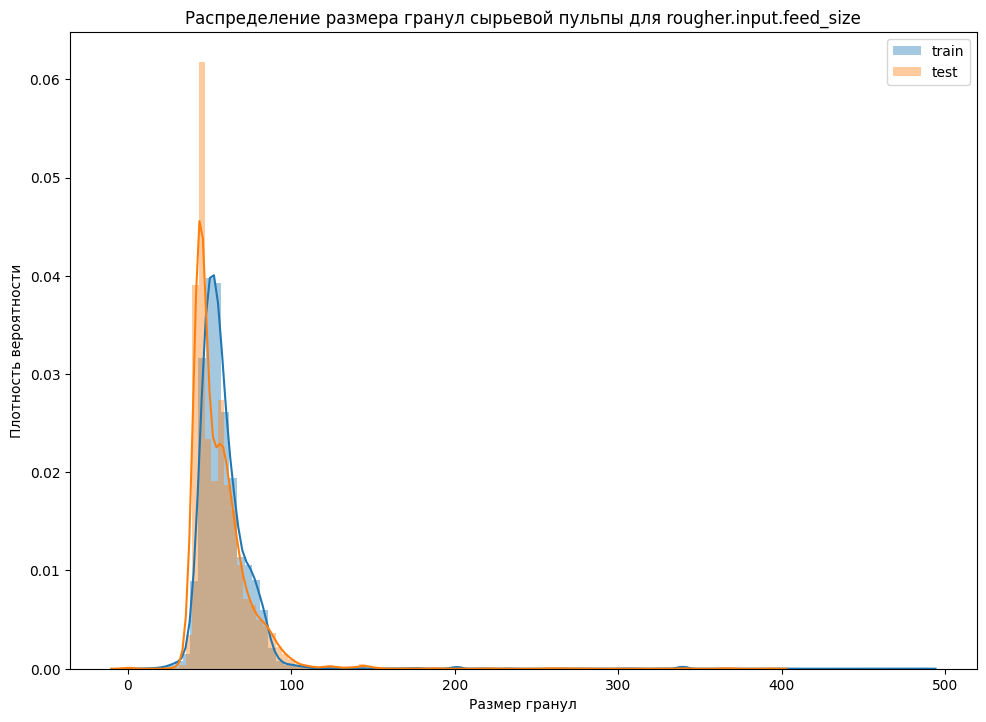

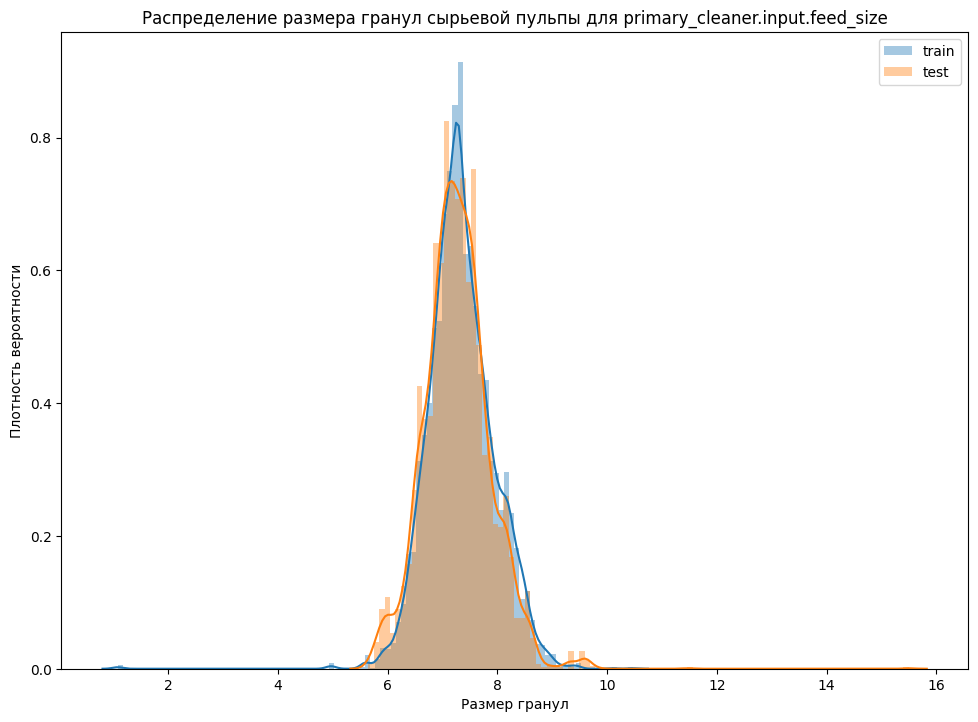

In [37]:
stages = ('rougher.input.feed_size', 'primary_cleaner.input.feed_size')

for stage in stages:
    f, ax = plt.subplots()
    sns.distplot(gold_recovery_train[stage], bins=100, label='train');
    sns.distplot(gold_recovery_test[stage], bins=100, label='test');
    plt.legend()
    ax.set(
        xlabel='Размер гранул', 
        ylabel='Плотность вероятности', 
        title=f'Распределение размера гранул сырьевой пульпы для {stage}'
    )
    plt.show()

**Промежуточные выводы:**
* На этапе флотации распределение размеров частиц для тестовой выборки смещено в область более мелких частиц. Нужно проверить, является ли это различие в средних двух выборок статистически значимым.
* На этапе первичной очистки распределения размеров частиц на обучающей и тестовой выборке совпадают. 

Проверим, действительно ли среднее распределения размера частиц на обучающей выборке больше среднего для тестовой выборки на уровне значимости 5%. 

**Нулевая гипотеза:** среднее обучающей выборки не больше среднего тестовой выборки 

**Альтернативная гипотеза:** среднее обучающей выборки больше среднего тестовой выборки.

In [38]:
alpha = .05
res = st.ttest_ind(
    gold_recovery_train['rougher.input.feed_size'], 
    gold_recovery_test['rougher.input.feed_size'], 
    alternative='greater'
)
if res.pvalue < alpha:
    print(f'''Среднее обучающей выборки больше среднего тестовой выборки при уровне значимости {alpha}. 
    p-value = {res.pvalue}''')
else:
    print(f'''Среднее обучающей выборки не больше среднего тестовой выборки при уровне значимости {alpha}. 
          p-value = {res.pvalue}''')

Среднее обучающей выборки больше среднего тестовой выборки при уровне значимости 0.05. 
    p-value = 8.523191922680722e-17


Как видно, распределения размера частиц на обучающей и тестовой выборок для этапа флотации статистически значимо различаются. Нужно обратиться к коллегам, предоставившим данные для уточнения причины этой несостыковки.

### Суммарные концентрации всех веществ на разных стадиях процесса <a class='anchor' id='total_concentrations'></a>

Проанализируем суммарные концентрации всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах.

Создадим отдельные объекты типа `pd.Series` для суммарных концентраций веществ на каждом этапе.

In [39]:
sum_concentrations_rougher_input = gold_recovery_train[
    [
        'rougher.input.feed_ag',
        'rougher.input.feed_pb',
        'rougher.input.feed_au', 
        'rougher.input.feed_sol'
    ]
].sum(axis=1)

sum_concentrations_rougher_output = gold_recovery_train[
    [
        'rougher.output.concentrate_ag',
        'rougher.output.concentrate_pb',
        'rougher.output.concentrate_au', 
        'rougher.output.concentrate_sol'
    ]
].sum(axis=1)

sum_concentrations_primary_cleaner = gold_recovery_train[
    [
        'primary_cleaner.output.concentrate_ag',
        'primary_cleaner.output.concentrate_pb',
        'primary_cleaner.output.concentrate_au', 
        'primary_cleaner.output.concentrate_sol'
    ]
].sum(axis=1)

sum_concentrations_final = gold_recovery_train[
    [
        'final.output.concentrate_ag',
        'final.output.concentrate_pb',
        'final.output.concentrate_au', 
        'final.output.concentrate_sol'
    ]
].sum(axis=1)

Объединим полученные объекты `pd.Series` в единый датафрейм. 

In [40]:
sum_concentrations = pd.DataFrame()
sum_concentrations['rougher_input'] = sum_concentrations_rougher_input
sum_concentrations['rougher_output'] = sum_concentrations_rougher_output
sum_concentrations['primary_cleaner'] = sum_concentrations_primary_cleaner
sum_concentrations['final'] = sum_concentrations_final

Построим распределения для суммарных концентраций всех веществ на каждом этапе.

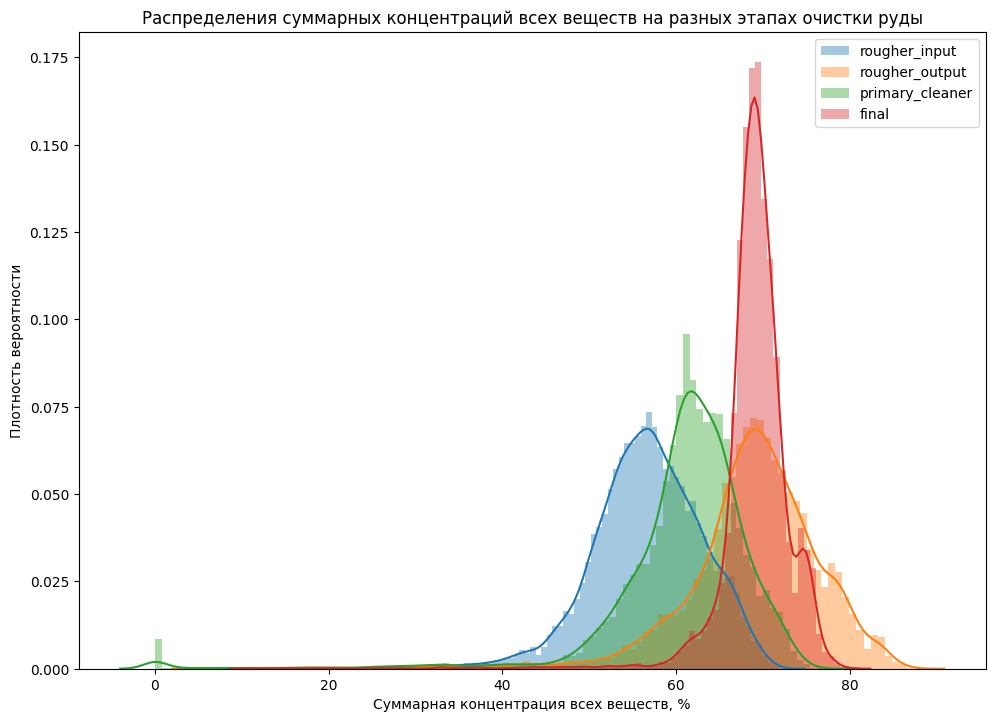

In [41]:
f, ax = plt.subplots()
sns.distplot(sum_concentrations['rougher_input'], bins=100, label='rougher_input')
sns.distplot(sum_concentrations['rougher_output'], bins=100, label='rougher_output')
sns.distplot(sum_concentrations['primary_cleaner'], bins=100, label='primary_cleaner')
sns.distplot(sum_concentrations['final'], bins=100, label='final')
plt.legend()
ax.set(
        xlabel='Суммарная концентрация всех веществ, %', 
        ylabel='Плотность вероятности', 
        title='Распределения суммарных концентраций всех веществ на разных этапах очистки руды'
    )
plt.show()

**Промежуточные выводы:**
* Суммарная концентрация всех веществ после проведения первичной очистки снижается в среднем на 10%, по сравнению с этапом флотации.
* Финальный концентрат содержит примерно одинаковое суммарное количество веществ, что и концентрат после флотации, однако распределение становится более узким.
* Для всех 3 этапов характерны хвосты ниже 40%. **Заметим, что в исходном сырье суммарная концентрация всех веществ попадает в интервал от 40 до 70%. Вероятно, эти хвосты ниже 40% на последующих этапах - выбросы, связанные с неточностью измерений. Удалим строки с такими значениями из обучающей выборки.**

Добавим в трейн дополнительные столбцы с суммарной концентрацией всех веществ на каждом этапе, включая исходное сырье.

In [42]:
gold_recovery_train['sum_concentrations_rougher_input'] = sum_concentrations_rougher_input
gold_recovery_train['sum_concentrations_rougher_output'] = sum_concentrations_rougher_output 
gold_recovery_train['sum_concentrations_primary_cleaner'] = sum_concentrations_primary_cleaner
gold_recovery_train['sum_concentrations_final'] = sum_concentrations_final

Удалим из обучающей выборки строки, где суммарная концентрация всех веществ ниже 40%.

In [43]:
gold_recovery_train = gold_recovery_train[
    (gold_recovery_train['sum_concentrations_rougher_input'] >= 40) & \
    (gold_recovery_train['sum_concentrations_rougher_output'] >= 40) & \
    (gold_recovery_train['sum_concentrations_primary_cleaner'] >= 40) & \
    (gold_recovery_train['sum_concentrations_final'] >= 40)
]

Обновим графики распределений суммарных концентраций всех веществ на разных этапах.

In [44]:
sum_concentrations['rougher_input'] = gold_recovery_train['sum_concentrations_rougher_input']
sum_concentrations['rougher_output'] = gold_recovery_train['sum_concentrations_rougher_output']
sum_concentrations['primary_cleaner'] = gold_recovery_train['sum_concentrations_primary_cleaner']
sum_concentrations['final'] = gold_recovery_train['sum_concentrations_final']

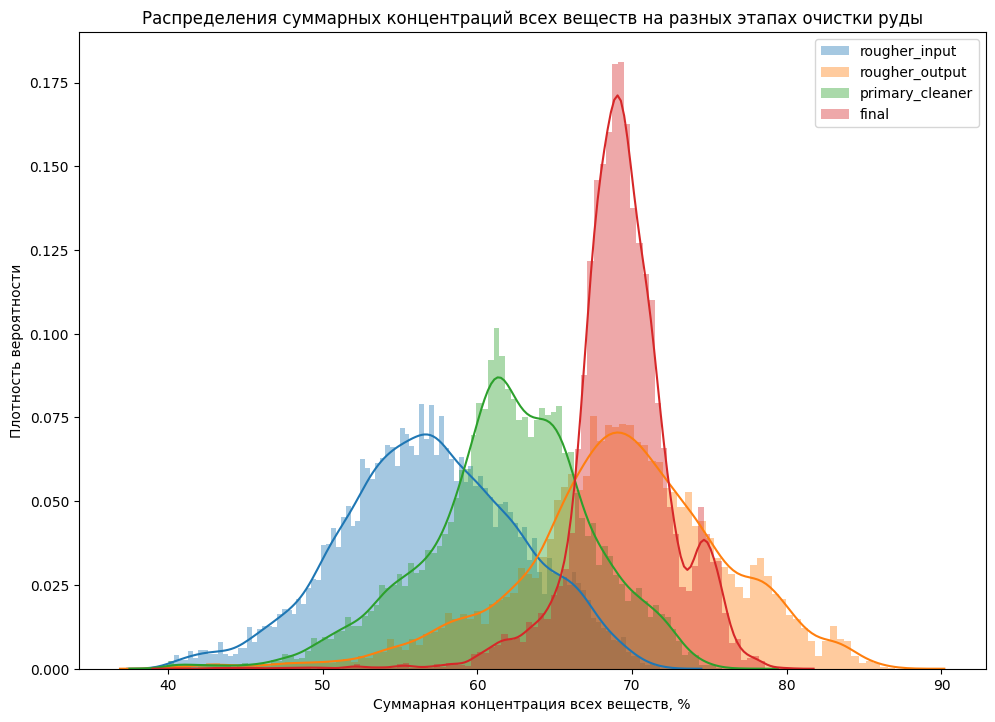

In [45]:
f, ax = plt.subplots()
sns.distplot(sum_concentrations['rougher_input'], bins=100, label='rougher_input')
sns.distplot(sum_concentrations['rougher_output'], bins=100, label='rougher_output')
sns.distplot(sum_concentrations['primary_cleaner'], bins=100, label='primary_cleaner')
sns.distplot(sum_concentrations['final'], bins=100, label='final')
plt.legend()
ax.set(
        xlabel='Суммарная концентрация всех веществ, %', 
        ylabel='Плотность вероятности', 
        title='Распределения суммарных концентраций всех веществ на разных этапах очистки руды'
    )
plt.show()

**Выводы по анализу данных**
* Проведен анализ изменений концентрации каждого металла в руде после каждого этапа обогащения: 
    * Для концентрации каждого металла после проведения флотации характерно ее повышение, по сравнению с исходным сырьем. Это может быть связано с тем, что на этапе флотации из руды извлекают примеси, следовательно, суммарное количество руды снижается, значит, доли оставшихся компонентов пропорционально вырастут
    * Концентрация серебра в руде падает с 12 до 4 % с каждым последующим этапом
    * Концентрация свинца увеличивается с 7.5% до уровня 10-11% после флотации и очистки
    * Концентрация золота повышается с каждым последующим этапом: с 20% до 32% - после флотации и до 45% после очистки
* Сопоставлены распределения размеров частиц для обучающей и тестовой выборок: 
    * На этапе флотации распределение размеров частиц для тестовой выборки смещено в область более мелких частиц. Это смещение статистически значимо (значимость на уровне 0.05). Нужно обратиться к коллегам, подготовившим данные, чтобы разобраться в причинах такого деления на трейн и тест.
    * На этапе первичной очистки распределения размеров частиц на обучающей и тестовой выборке совпадают. 
* Проанализированы распределения суммарных концентраций всех веществ на каждом этапе обогащения:
    * Суммарная концентрация всех веществ после проведения первичной очистки снижается в среднем на 10%, по сравнению с этапом флотации.
    * Финальный концентрат содержит примерно одинаковое суммарное количество веществ, что и концентрат после флотации, однако распределение становится более узким.
    * Для всех 3 этапов характерны хвосты ниже 40%. **Строки с такими значениями были отнесены к выбросам и удалены из обучающей выборки.**

## Модель <a class='anchor' id='model'></a>

Прежде чем приступать к данному этапу, оставим в обучающей выборке только те признаки, которые есть в тестовой.

In [46]:
gold_recovery_train_total = gold_recovery_train.copy(deep=True) 
for column in gold_recovery_train_total.columns:
    if column not in gold_recovery_test.columns.to_list():
        gold_recovery_train_total = gold_recovery_train_total.drop(column, axis=1)

Проверим размеры трейна и теста.

In [47]:
print(gold_recovery_train_total.shape, gold_recovery_test.shape, sep='\n')

(10978, 55)
(5229, 55)


Количество признаков одинаково в обеих выборках. Двигаемся дальше.

### Метрика качества модели <a class='anchor' id='metrics'></a>

В качестве метрики качества модели выбрано симметричное абсолютное процентное отклонение `sMAPE`. Для корректной оценки нужно сделать 2 модели: прогноз эффективности обогащения чернового и финального концентратов. Итоговая метрика будет рассчитана с учетом весов `sMAPE` этих 2-х моделей: 25% - для модели по черновому концентрату и 75% - для модели по финальному концентрату.

Напишем функцию для расчета итоговой `sMAPE`

In [48]:
def sMAPE_calc(
    col_target_rougher: pd.Series, 
    col_predicted_rougher: pd.Series, 
    col_target_final: pd.Series, 
    col_predicted_final: pd.Series) -> float:
    
    sMAPE_rougher = (
        np.abs(col_target_rougher - col_predicted_rougher) / ((np.abs(col_target_rougher) + np.abs(col_predicted_rougher)) / 2)
    ).sum() / len(col_target_rougher) * 100
    
    sMAPE_final = (
        np.abs(col_target_final - col_predicted_final) / ((np.abs(col_target_final) + np.abs(col_predicted_final)) / 2) 
    ).sum() / len(col_target_final) * 100
    return 0.25 * sMAPE_rougher + 0.75 * sMAPE_final 

### Разбивка данных на обучающую и валидационную выборки <a class='anchor' id='split'></a>

Разобьем трейн на обучающую и валидационную выборки в соотношении 75% : 25%.

In [49]:
features = (
    gold_recovery_train_total.drop(['date', 'rougher.output.recovery', 'final.output.recovery'], axis=1)
)
target = gold_recovery_train_total[['rougher.output.recovery', 'final.output.recovery']] 

In [50]:
features_train, features_valid, target_train, target_valid = (
    train_test_split(features, target, test_size=0.25, random_state=12345)
)

Выведем размеры выборок.

In [51]:
print(f'Размер признаков и целевого признака для обучающей выборки равны, соответственно: \
{features_train.shape} и {target_train.shape}')
print(f'Размер признаков и целевого признака для валидационной выборки равны, соответственно: \
{features_valid.shape} и {target_valid.shape}')

Размер признаков и целевого признака для обучающей выборки равны, соответственно: (8233, 52) и (8233, 2)
Размер признаков и целевого признака для валидационной выборки равны, соответственно: (2745, 52) и (2745, 2)


Сбросим индексы.

In [52]:
features_train = features_train.reset_index(drop=True)
features_valid = features_valid.reset_index(drop=True)
target_train = target_train.reset_index(drop=True)
target_valid = target_valid.reset_index(drop=True)

### Модель дерева решений <a class='anchor' id='tree'></a>

Создадим и обучим модель дерева решений для прогнозирования эффективности обогащения чернового и финального концентрата.

In [53]:
best_model_tree = None
best_depth_tree = 0
best_res_tree = 100
for i in tqdm(range(1, 20)):
    model_tree = DecisionTreeRegressor(random_state=12345, max_depth=i)
    model_tree.fit(features_train, target_train)
    predicted_tree = pd.DataFrame(
        data=model_tree.predict(features_valid), 
        columns=['rougher_predicted_valid', 'final_predicted_valid']
    )
    sMAPE_tree = sMAPE_calc(
        col_target_rougher=target_valid['rougher.output.recovery'],
        col_predicted_rougher=predicted_tree['rougher_predicted_valid'],
        col_target_final=target_valid['final.output.recovery'],
        col_predicted_final=predicted_tree['final_predicted_valid']
    ) 
    if sMAPE_tree < best_res_tree: 
        best_res_tree = sMAPE_tree 
        best_model_tree = model_tree
        best_depth_tree = i
tqdm.write(f'Лучшее sMAPE модели дерева решений, {best_res_tree}, достигается при глубине дерева, равной {best_depth_tree}')

100%|██████████| 19/19 [00:11<00:00,  1.68it/s]

Лучшее sMAPE модели дерева решений, 5.3733349602502205, достигается при глубине дерева, равной 15


### Модель случайного леса <a class='anchor' id='forest'></a>

Создадим и обучим модель случайного леса для прогнозирования эффективности обогащения чернового и финального концентрата.

In [54]:
best_model_rand_forest = None
best_estimators_rand_forest = 0
best_depth_rand_forest = 0
best_res_rand_forest = 100
for i in tqdm(range(1, 16)):
    for j in range(1, 20):
        model_rand_forest = RandomForestRegressor(random_state=12345, n_estimators=i, max_depth=j)
        model_rand_forest.fit(features_train, target_train)
        predicted_rand_forest = pd.DataFrame(
            data=model_rand_forest.predict(features_valid), 
            columns=['rougher_predicted_valid', 'final_predicted_valid']
        )
        sMAPE_rand_forest = sMAPE_calc(
            col_target_rougher=target_valid['rougher.output.recovery'],
            col_predicted_rougher=predicted_rand_forest['rougher_predicted_valid'],
            col_target_final=target_valid['final.output.recovery'],
            col_predicted_final=predicted_rand_forest['final_predicted_valid']
        ) 
        if sMAPE_rand_forest < best_res_rand_forest: 
            best_res_rand_forest = sMAPE_rand_forest 
            best_model_rand_forest = model_rand_forest
            best_estimators_rand_forest = i
            best_depth_rand_forest = j
tqdm.write(
    f'''
    Лучшая точность модели случайного леса, {best_res_rand_forest}, 
    достигается при количестве деревьев, равном {best_estimators_rand_forest}, и глубине дерева, равной {best_depth_rand_forest}
    ''')

100%|██████████| 15/15 [15:16<00:00, 61.12s/it]


    Лучшая точность модели случайного леса, 4.142955182509221, 
    достигается при количестве деревьев, равном 15, и глубине дерева, равной 19
    


### Модель линейной регрессии <a class='anchor' id='regression'></a>

Создадим и обучим модель линейной регрессии для прогнозирования эффективности обогащения чернового и финального концентрата.

In [55]:
model_liner_regression = LinearRegression()
model_liner_regression.fit(features_train, target_train)
predicted_liner_regression = pd.DataFrame(
    data=model_liner_regression.predict(features_valid), 
    columns=['rougher_predicted_valid', 'final_predicted_valid']
)
sMAPE_liner_regression = sMAPE_calc(
    col_target_rougher=target_valid['rougher.output.recovery'],
    col_predicted_rougher=predicted_liner_regression['rougher_predicted_valid'],
    col_target_final=target_valid['final.output.recovery'],
    col_predicted_final=predicted_liner_regression['final_predicted_valid']
) 

print(f'Точность модели линейной регрессии составляет {sMAPE_liner_regression}')

Точность модели линейной регрессии составляет 6.058293644436025


**Промежуточные выводы:**
* Для прогнозирования эффективности обогащения чернового и финального концентратов обучены 3 модели:
    * Дерево решений
    * Случайный лес
    * Линейная регрессия
* sMAPE обученных моделей на валидационной выборке составили:
    * Дерево решений - 5.37% (глубина равна 15)
    * Случайный лес - 4.14% (15 деревьев, глубина каждого дерева равна 19)
    * Линейная регрессия - 6.06%
* Для работы с тестовой выборкой используем модель случайного леса

### Испытание лучшей модели на тестовой выборке <a class='anchor' id='test'></a>

Выделим целевые признаки и регрессоры из тестовой выборки.

In [56]:
features_test = gold_recovery_test.drop(['date', 'rougher.output.recovery', 'final.output.recovery'], axis=1)
target_test = gold_recovery_test[['rougher.output.recovery', 'final.output.recovery']] 

Используем модель случайного леса на тестовой выборке.

In [57]:
predicted_rand_forest_test = pd.DataFrame(
    data=best_model_rand_forest.predict(features_test), 
    columns=['rougher_predicted_valid', 'final_predicted_valid']
)
sMAPE_rand_forest_test = sMAPE_calc(
    col_target_rougher=target_test['rougher.output.recovery'],
    col_predicted_rougher=predicted_rand_forest_test['rougher_predicted_valid'],
    col_target_final=target_test['final.output.recovery'],
    col_predicted_final=predicted_rand_forest_test['final_predicted_valid']
) 

print(f'Точность модели случайного леса на тестовой выборке составляет {sMAPE_rand_forest_test}')

Точность модели случайного леса на тестовой выборке составляет 6.600124477703118


Точность понизилась, по сравнению с валидационной выборкой, что может говорить о переобучении модели. Также это может быть связано с неодинаковым распределением размеров гранул на трейне и тесте, как мы выяснили в ходе анализа данных.

### Проверка лучшей модели на адекватность <a class='anchor' id='adequate'></a>

Для проверки адекватности используем класс `DummyRegressor()`. Данный класс позволяет предсказать значение целевого признака, не опираясь на зависимости между целевым признаком и другими признаками. В этом случае предсказания делаются только на основе массива значений целевого признака, значения других признаков игнорируются. Если полученная точность модели `Dummy` будет ниже нашей лучшей модели случайного леса, то нашу модель можно считать адекватной.

In [58]:
model_dummy = DummyRegressor()
model_dummy.fit(features_train, target_train)
predicted_dummy_test = pd.DataFrame(
    data=model_dummy.predict(features_test), 
    columns=['rougher_predicted_valid', 'final_predicted_valid']
)
sMAPE_dummy_test = sMAPE_calc(
    col_target_rougher=target_test['rougher.output.recovery'],
    col_predicted_rougher=predicted_dummy_test['rougher_predicted_valid'],
    col_target_final=target_test['final.output.recovery'],
    col_predicted_final=predicted_dummy_test['final_predicted_valid']
) 

print(f'Точность модели dummy на тестовой выборке составляет {sMAPE_dummy_test}')

Точность модели dummy на тестовой выборке составляет 6.8553684766512415


Точность модели `dummy` ниже, чем в случае случайного леса, значит, наша модель адекватна.

## Выводы по проекту <a class='anchor' id='conclusions'></a>

* В рамках настоящей работы разработан прототип модели линейной регрессии для прогнозирования эффективности обогащения чернового и финального концентратов. 
* `sMAPE` модели случайного леса на валидационной выборке составило `4.14%`, не тестовой - `6.60%`. Модель является адекватной. 
* Дополнительно исследованы модели дерева решений и линейной регрессии. Однако на валидационной выборке они показали более низкие результаты: `5.37%` - дерево решений и `6.06%` - линейная регрессия.